In [64]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

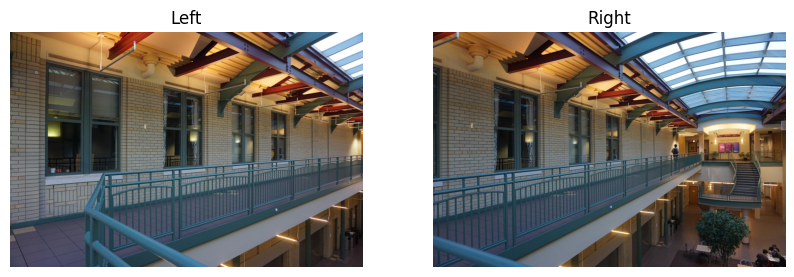

In [65]:
img1 = cv2.imread('data\\medium_left.png')
img2 = cv2.imread('data\\medium_right.png')

# 將 BGR 圖像轉換為 RGB 以便使用 matplotlib 繪製
cropped_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
cropped_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


# 繪製剪裁後的圖像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Left')
plt.imshow(cropped_img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Right')
plt.imshow(cropped_img2)
plt.axis('off')

plt.show()


In [66]:
#定義要拼接的左圖和右圖
left_img = cropped_img1
right_img = cropped_img2

#定義遮罩寬度
mask_width1 = 1000
mask_width2 = 1000

# 左圖遮罩對齊右邊
mask1 = np.zeros(left_img.shape[:2], dtype=np.uint8)
mask1[:, -mask_width1:] = 255

# 右圖遮罩對齊左邊
mask2 = np.zeros(right_img.shape[:2], dtype=np.uint8)
mask2[:, :mask_width2] = 255

### SIFT

In [67]:
# 創建 SIFT 物件
sift = cv2.SIFT_create() # type: ignore

# 提取特徵點和描述子
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(left_img, mask1)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(right_img, mask2)

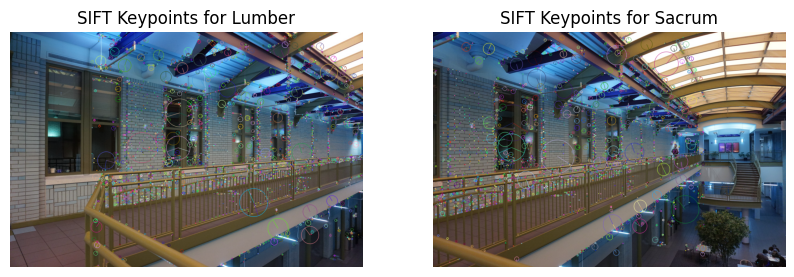

In [68]:
plt.figure(figsize=(10, 5))

# 繪製特徵點
left_img_with_keypoints = cv2.drawKeypoints(left_img, keypoints1_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore
right_img_with_keypoints = cv2.drawKeypoints(right_img, keypoints2_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore

plt.subplot(1, 2, 1)
plt.title('SIFT Keypoints for Lumber')
plt.imshow(cv2.cvtColor(left_img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SIFT Keypoints for Sacrum')
plt.imshow(cv2.cvtColor(right_img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Number of good matches: 1273


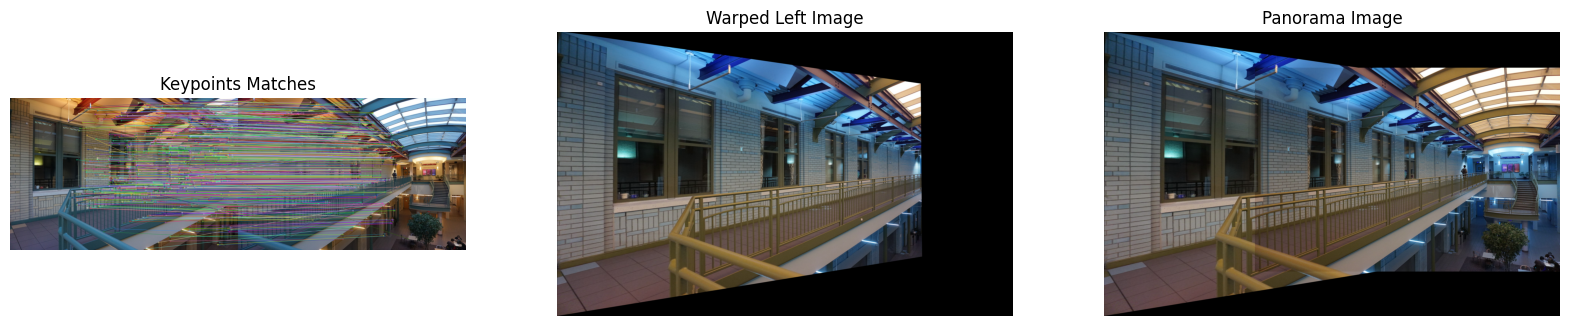

In [69]:
# 提取特徵點和描述子
keypoints1, descriptors1 = sift.detectAndCompute(left_img, mask1)
keypoints2, descriptors2 = sift.detectAndCompute(right_img, mask2)

# 特徵匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# 只保留好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# 檢查匹配數量
print(f'Number of good matches: {len(good_matches)}')

# 提取匹配點
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    # 使用 RANSAC 方法估計單應矩陣
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 計算變形後的圖像邊界
    left_img_h, left_img_w = left_img.shape[:2]
    right_img_h, right_img_w = right_img.shape[:2]
    corners_left = np.float32([[0, 0], [0, left_img_h], [left_img_w, left_img_h], [left_img_w, 0]]).reshape(-1, 1, 2)
    corners_right = np.float32([[0, 0], [0, right_img_h], [right_img_w, right_img_h], [right_img_w, 0]]).reshape(-1, 1, 2)
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H)
    corners_combined = np.concatenate((corners_right, corners_left_transformed), axis=0)

    # 找到拼接圖像的邊界
    [xmin, ymin] = np.int32(corners_combined.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners_combined.max(axis=0).ravel() + 0.5)

    # 計算平移變換矩陣
    translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    
    # 將左圖變形並平移
    warped_left_img = cv2.warpPerspective(left_img, translation.dot(H), (xmax - xmin, ymax - ymin))

    # 將右圖放置在平移後的畫布上
    result_img = warped_left_img.copy()
    result_img[-ymin:right_img_h - ymin, -xmin:right_img_w - xmin] = right_img

    # 繪製匹配點
    matches_img = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title('Keypoints Matches')
    plt.imshow(matches_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Warped Left Image')
    plt.imshow(cv2.cvtColor(warped_left_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Panorama Image')
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
else:
    print('Not enough good matches to compute homography.')

### ORB

In [70]:
# 創建 ORB 物件
orb = cv2.ORB_create() # type: ignore

# 提取 ORB 特徵點和描述子
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(left_img, mask1)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(right_img, mask2)

Number of good matches: 77


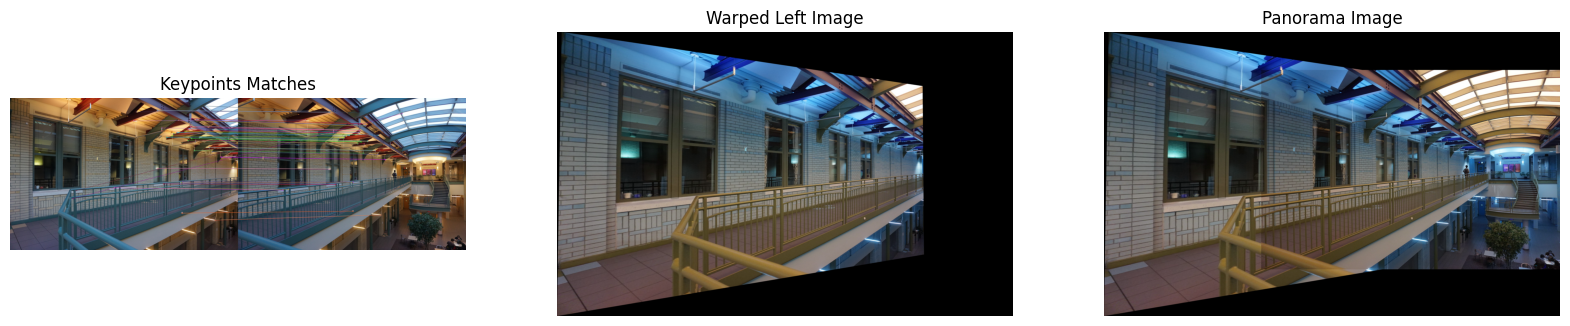

In [71]:
# 提取特徵點和描述子
keypoints1, descriptors1 = orb.detectAndCompute(left_img, mask1)
keypoints2, descriptors2 = orb.detectAndCompute(right_img, mask2)

# 特徵匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# 只保留好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# 檢查匹配數量
print(f'Number of good matches: {len(good_matches)}')

# 提取匹配點
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2) # type: ignore

    # 使用 RANSAC 方法估計單應矩陣
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 計算變形後的圖像邊界
    left_img_h, left_img_w = left_img.shape[:2]
    right_img_h, right_img_w = right_img.shape[:2]
    corners_left = np.float32([[0, 0], [0, left_img_h], [left_img_w, left_img_h], [left_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_right = np.float32([[0, 0], [0, right_img_h], [right_img_w, right_img_h], [right_img_w, 0]]).reshape(-1, 1, 2) # type: ignore
    corners_left_transformed = cv2.perspectiveTransform(corners_left, H)
    corners_combined = np.concatenate((corners_right, corners_left_transformed), axis=0)

    # 找到拼接圖像的邊界
    [xmin, ymin] = np.int32(corners_combined.min(axis=0).ravel() - 0.5) # type: ignore
    [xmax, ymax] = np.int32(corners_combined.max(axis=0).ravel() + 0.5) # type: ignore

    # 計算平移變換矩陣
    translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    
    # 將左圖變形並平移
    warped_left_img = cv2.warpPerspective(left_img, translation.dot(H), (xmax - xmin, ymax - ymin))

    # 將右圖放置在平移後的畫布上
    result_img = warped_left_img.copy()
    result_img[-ymin:right_img_h - ymin, -xmin:right_img_w - xmin] = right_img

    # 繪製匹配點
    matches_img = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # type: ignore

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title('Keypoints Matches')
    plt.imshow(matches_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Warped Left Image')
    plt.imshow(cv2.cvtColor(warped_left_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Panorama Image')
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
else:
    print('Not enough good matches to compute homography.')

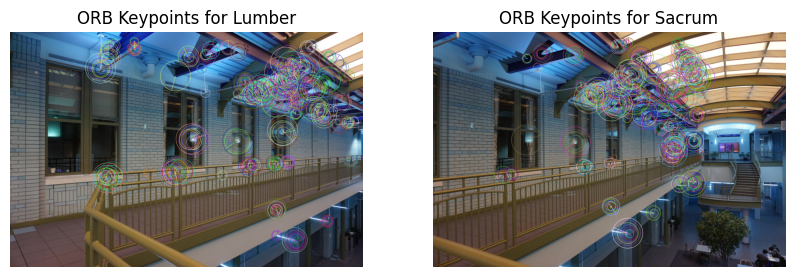

In [72]:
plt.figure(figsize=(10, 5))

# 繪製特徵點
left_img_with_keypoints = cv2.drawKeypoints(left_img, keypoints1_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore
right_img_with_keypoints = cv2.drawKeypoints(right_img, keypoints2_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # type: ignore

plt.subplot(1, 2, 1)
plt.title('ORB Keypoints for Lumber')
plt.imshow(cv2.cvtColor(left_img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('ORB Keypoints for Sacrum')
plt.imshow(cv2.cvtColor(right_img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

### Harris

In [73]:
# 提取 Harris 角點
def harris_corner_detector(img, mask, blockSize=2, ksize=3, k=0.04):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize, ksize, k) # type: ignore
    dst = cv2.dilate(dst, None) # type: ignore
    
    # 應用遮罩
    dst_masked = cv2.bitwise_and(dst, dst, mask=mask)
    img[dst_masked > 0.01 * dst.max()] = [0, 0, 255]
    return img

harris1 = harris_corner_detector(left_img.copy(), mask1)
harris2 = harris_corner_detector(right_img.copy(), mask2)

# 調整參數，嘗試不同的參數組合
harris1_adjusted = harris_corner_detector(left_img.copy(), mask1, blockSize=4, ksize=5, k=0.06)
harris2_adjusted = harris_corner_detector(right_img.copy(), mask2, blockSize=4, ksize=5, k=0.06)


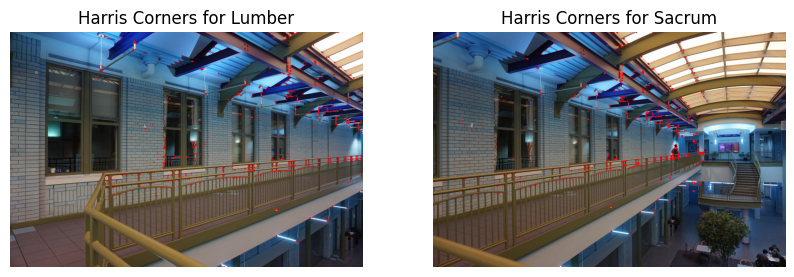

In [74]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Harris Corners for Lumber')
plt.imshow(cv2.cvtColor(harris1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Harris Corners for Sacrum')
plt.imshow(cv2.cvtColor(harris2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()